![img](http://www.techbucket.org/wp-content/uploads/2012/07/Search-Engine-Optimization.jpg)

In [2]:
import numpy as np
np.random.seed(1019)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import xgboost

import sklearn
from sklearn.model_selection import train_test_split 

import sys, os, gc, types
import time
from subprocess import check_output

In [3]:
sys.path.append('./utils')
from training import cv

In [4]:
root_paths = [
    "/data/kaggle-instacart",
    "/Users/jiayou/Dropbox/珺珺的程序/Kaggle/Instacart",
    "/Users/jiayou/Dropbox/Documents/珺珺的程序/Kaggle/Instacart"
]
root = None
for p in root_paths:
    if os.path.exists(p):
        root = p
        break

# Search Parameters

In [26]:
name = 'r0'
down_sample = 10
num_searches = 25
boosting_rounds = 200
stopping_rounds = 5

xgb_params_search = {
    "learning_rate"    : lambda: int(10**np.random.uniform(-2, -1) * 1e4) / 1e4,
    "max_depth"        : lambda: np.random.randint(3, 7),
    "min_split_loss"   : [0, 0.70],
    "min_child_weight" : [1, 10],
}
xgb_params_default = {
    "booster"          : "gbtree",
    "tree_method"      : "auto",
    "learning_rate"    : 0.1,
    "min_split_loss"   : 0.70, # ?
    "max_depth"        : 6,
    "min_child_weight" : 10, # hessian weight
    "subsample"        : 0.7,
    "colsample_bytree" : 0.9,
    "reg_alpha"        : 2e-05,
    "reg_lambda"       : 10,
    
    "objective"        : "reg:logistic",
    "eval_metric"      : "logloss"
}

----

# Explore

In [32]:
p = pd.read_csv(os.path.join(root, 'search-{}-params.csv'.format(name)))
p = p[list(xgb_params_search.keys()) + ['search_id']]
h = pd.read_csv(os.path.join(root, 'search-{}-histories.csv'.format(name)))
r = p.merge(h[h.boost_round == boosting_rounds - 1], on='search_id')

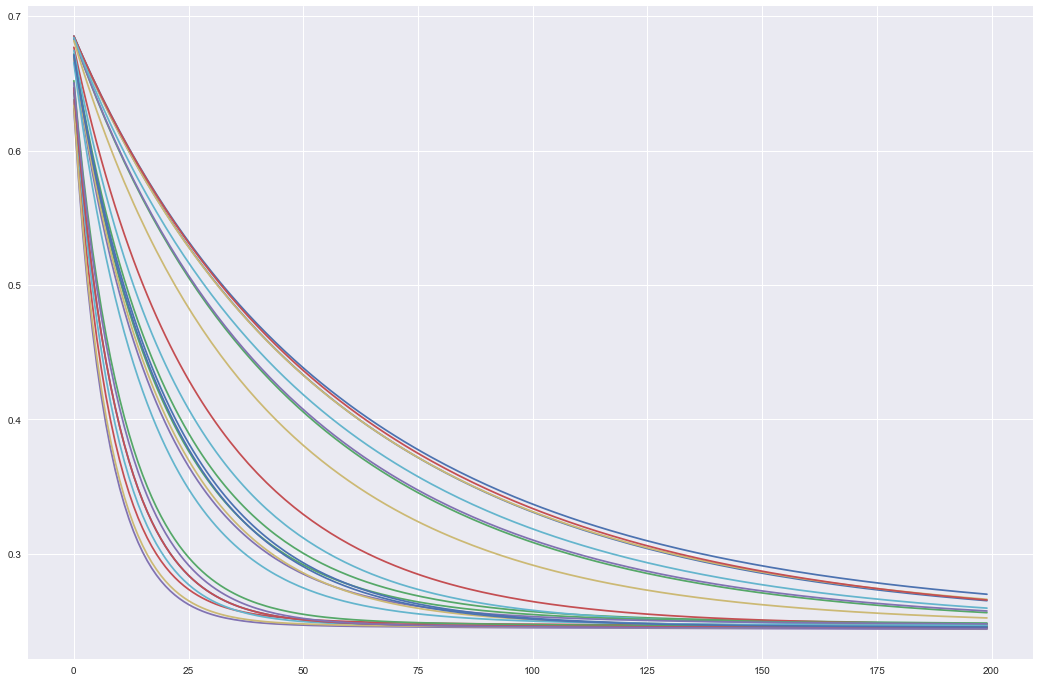

In [12]:
plt.figure(figsize=(18, 12))
for i in range(num_searches):
    plt.plot(h['boost_round'][h.search_id == i], h['test-logloss-mean'][h.search_id == i])
plt.show()

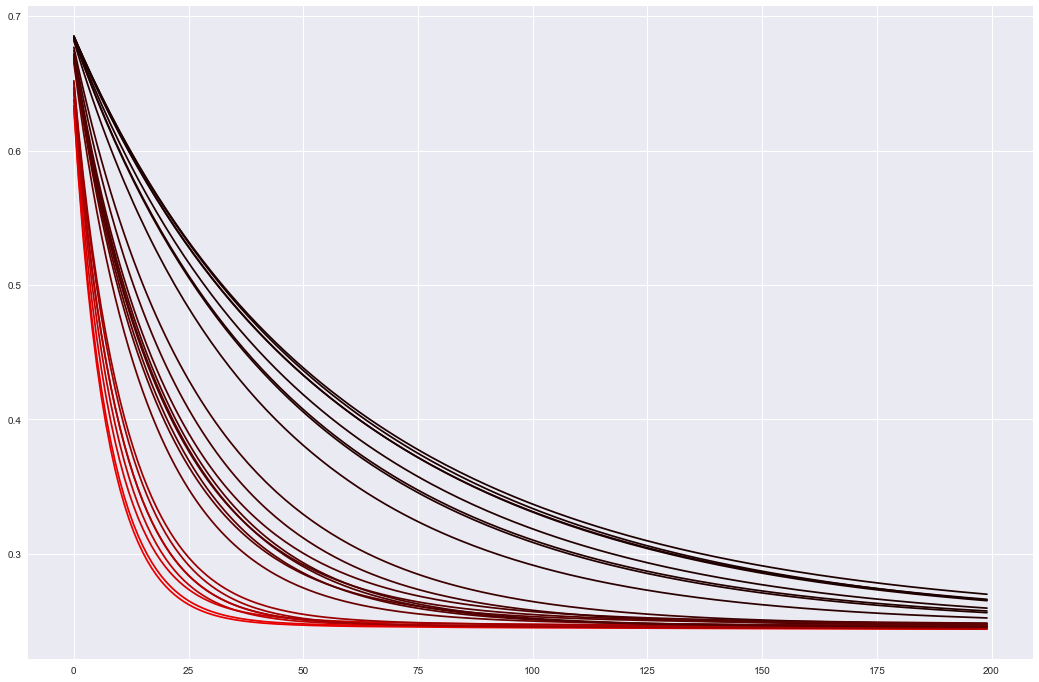

In [19]:
plt.figure(figsize=(18, 12))
for i in range(num_searches):
    c = (p.learning_rate[i]*10, 0, 0)
    plt.plot(h['boost_round'][h.search_id == i], h['test-logloss-mean'][h.search_id == i], color=c)
plt.show()

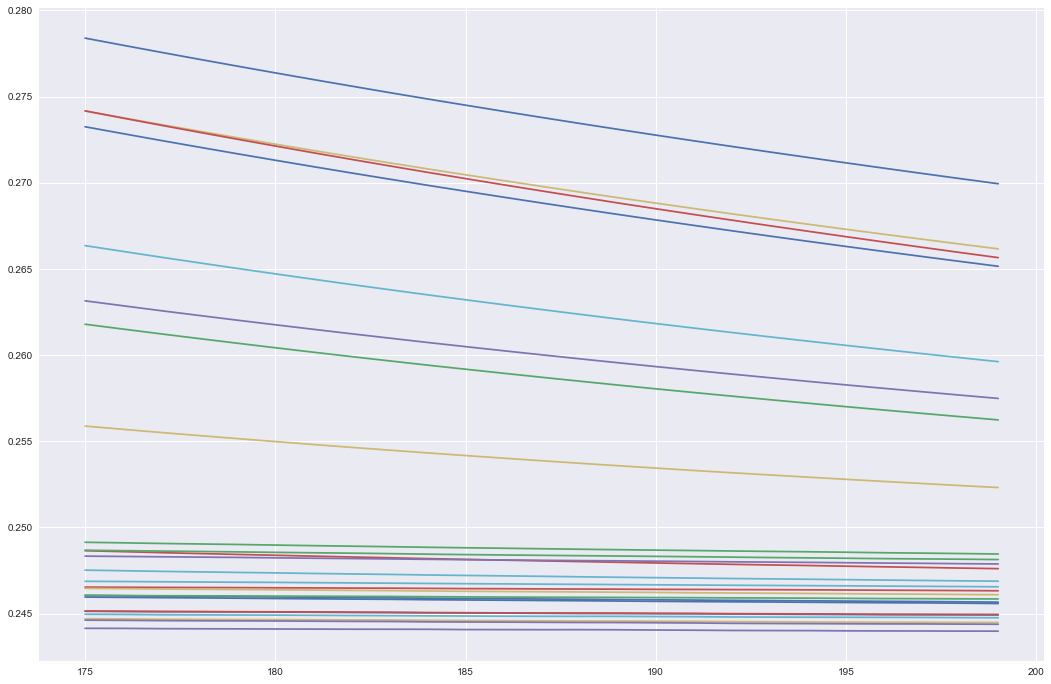

In [17]:
plt.figure(figsize=(18, 12))
for i in range(num_searches):
    plt.plot(h['boost_round'][h.search_id == i][175:], h['test-logloss-mean'][h.search_id == i][175:])
plt.show()

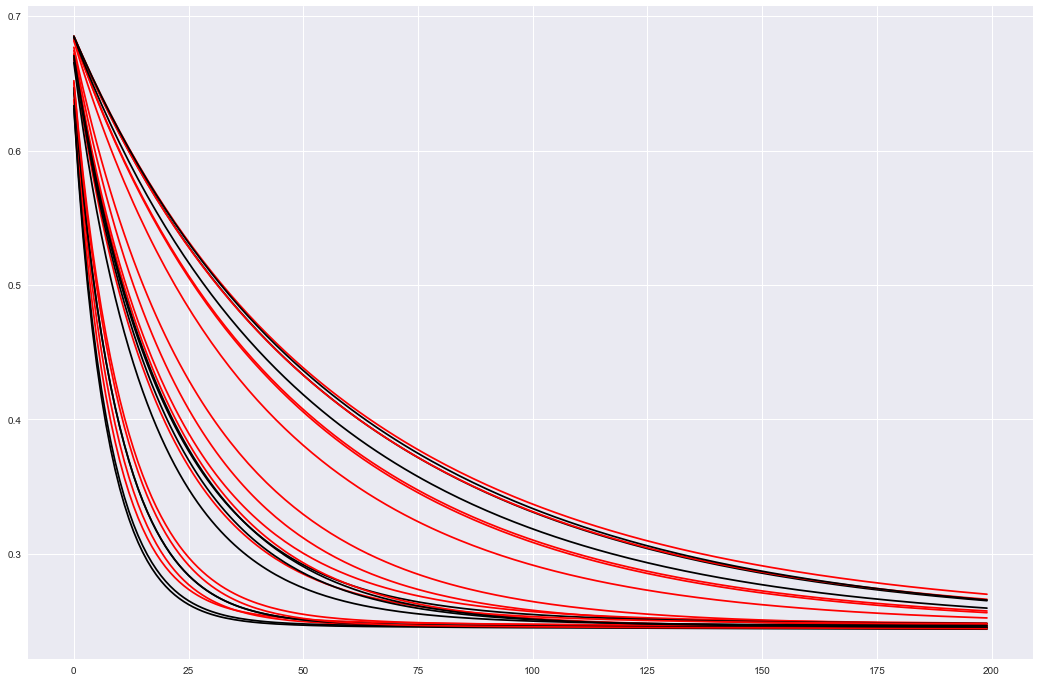

In [16]:
plt.figure(figsize=(18, 12))
for i in range(num_searches):
    c = 'r'
    if p.min_split_loss[i] < 0.1:
        c = 'k'
    plt.plot(h['boost_round'][h.search_id == i], h['test-logloss-mean'][h.search_id == i], c)
plt.show()

In [33]:
r.head()

,learning_rate,max_depth,min_split_loss,min_child_weight,search_id,test-logloss-mean,test-logloss-std,train-logloss-mean,train-logloss-std,boost_round
0,0.0117,5,0.0,10,0,0.265155,0.000484,0.264597,0.000164,199
1,0.0308,3,0.7,1,1,0.248454,0.000526,0.248016,0.000174,199
2,0.0234,5,0.7,10,2,0.247604,0.000546,0.246436,0.000172,199
3,0.0917,6,0.0,10,3,0.243978,0.000577,0.237046,0.000172,199
4,0.0118,4,0.7,10,4,0.266165,0.000469,0.265858,0.000163,199


In [60]:
def coinfluence(p1, p2):
    plt.figure(figsize=(18, 5))
    plt.xlabel(p1)
    plt.ylabel(p2)
    plt.scatter(
        r[p1], r[p2], 
        s=(r['test-logloss-mean'] - r['test-logloss-mean'].min()) * 100000 + 100, 
        alpha=0.5)

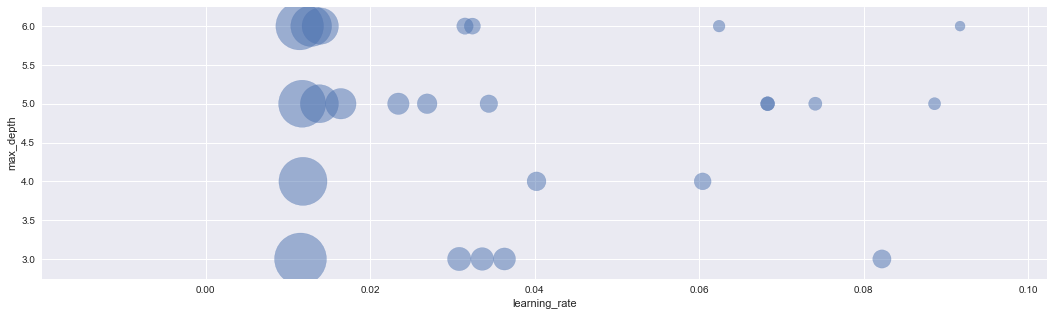

In [61]:
coinfluence('learning_rate', 'max_depth')

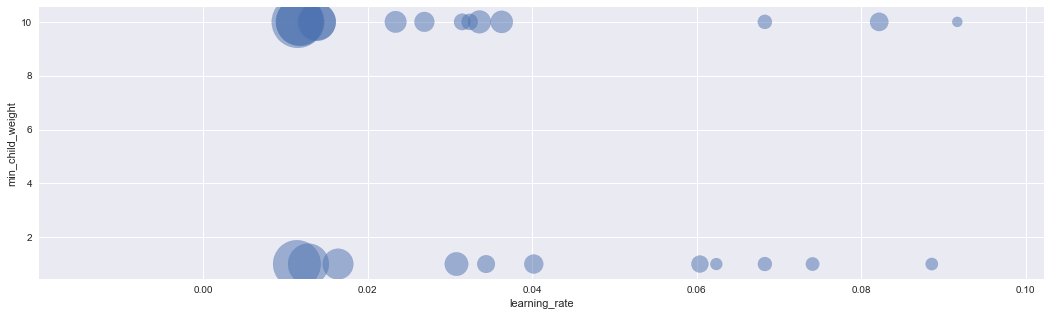

In [63]:
coinfluence('learning_rate', 'min_child_weight')

In [64]:
r

,learning_rate,max_depth,min_split_loss,min_child_weight,search_id,test-logloss-mean,test-logloss-std,train-logloss-mean,train-logloss-std,boost_round
0,0.0117,5,0.0,10,0,0.265155,0.000484,0.264597,0.000164,199
1,0.0308,3,0.7,1,1,0.248454,0.000526,0.248016,0.000174,199
2,0.0234,5,0.7,10,2,0.247604,0.000546,0.246436,0.000172,199
3,0.0917,6,0.0,10,3,0.243978,0.000577,0.237046,0.000172,199
4,0.0118,4,0.7,10,4,0.266165,0.000469,0.265858,0.000163,199
5,0.0269,5,0.7,10,5,0.246878,0.000531,0.245533,0.000180,199
6,0.0115,3,0.7,10,6,0.269946,0.000418,0.269805,0.000167,199
7,0.0336,3,0.0,10,7,0.248133,0.000543,0.247636,0.000171,199
8,0.0822,3,0.7,10,8,0.246321,0.000568,0.245296,0.000158,199
9,0.0363,3,0.7,10,9,0.247878,0.000542,0.247362,0.000176,199
